In [21]:
using LinearAlgebra
using Distributed
using SharedArrays
using Plots
using DataFrames, CSV

In [3]:
include("src/model.jl")

Main.CESModel

## Loading in Data

In [4]:
data = CESModel.read_data("I-O_DE2019_formatiert.csv")

Main.CESModel.CESData(84×87 DataFrame
 Row │ Sektoren                           Erz. d. Landwirtschaft, Jagd und Die ⋯
     │ String                             Int64                                ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Erz. d. Landwirtschaft, Jagd und…                                       ⋯
   2 │ Forstwirtschaftl. Erzeugnisse un…
   3 │ Fische, Fischerei- und Aquakultu…
   4 │ Kohle
   5 │ Erdöl und Erdgas                                                        ⋯
   6 │ Erze, Steine und Erden, sonstige…
   7 │ Nahrungs- u. Futtermittel, Geträ…
   8 │ Textilien, Bekleidung, Leder und…
  ⋮  │                 ⋮                                          ⋮            ⋱
  78 │ Bruttolöhne und -gehälter                                               ⋯
  79 │ Sonst.Produktionsabgaben abzgl. …
  80 │ Abschreibungen
  81 │ Nettobetriebsüberschuss
  82 │ Bruttowertschöpfung                                                     ⋯
  

## Setting Elasticities

Es können verschiedene Elastizitäten gesetzt werden, die hier verwendeten sind übernommen aus B&F 2019 
(el. of substitiution of inermediates = 0.0001, el labor/intermediates  = 0.5 el. of consumption = 0.9)

In [5]:
elasticities = CESModel.Elasticities(0.0001, 0.5, 0.9)

Main.CESModel.Elasticities(0.0001, 0.5, 0.9)

## Setting Shocks

Shocks können entweder mit `calculate_investment!` in  1000€ eingegeben werden, oder die einzelnen Elemente im Vektor können auch direkt verändernt werden (z.b `supply_shock[12] = 1.2`), was dann einem Anstieg an demand von 20% entsrpicht.

In [6]:
deman_shock = ones(71)
supply_shock = ones(71)
shocks = CESModel.Shocks(supply_shock, deman_shock)
#shocks.demand_shock[35] = 1.09
CESModel.calculate_investment!(shocks, data, 25000, "Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten")

1.2048978788971576

## Full labor reallocation

In [7]:
price, quantity = CESModel.solve_ces_model(data, shocks, elasticities)

([0.9414662771283996, 0.6855770600909871, 0.6244054586459472, 0.7988094318208036, 0.72560800011063, 0.7980692412591359, 0.9413472751142242, 0.8399371285656841, 0.7209376231454446, 0.9065230798549605  …  0.9374540563116732, 0.9365461354636719, 0.9396953689492532, 0.9447017210433897, 0.9573774851060077, 0.938480831665168, 0.9357786376989151, 0.9267620543014244, 0.8651271003502765, 0.9377494149784271], [0.017822842569161338, 0.0026980482430791456, 0.00019236861163893568, 0.001048461529185728, 0.0005707884229604307, 0.005050754335328761, 0.06459037348601991, 0.007634823324171928, 0.009157820799896372, 0.014907716432191008  …  0.08476074351186004, 0.011993745199906808, 0.05922054719919948, 0.07762445712314177, 0.034953554011502665, 0.011428410192898692, 0.009859295553372088, 0.014517220159642874, 0.0015135389093517662, 0.01793051333348333])

In [8]:
println("Real GDP: $(CESModel.real_gdp(price,quantity,data))")
println("Nominal GDP: $(CESModel.nominal_gdp(price,quantity,data))")


Real GDP: 1.0996241642069235


Nominal GDP: 0.9562693811307962


## No labor reallocation 

Es können verschiedene Funktionen angegeben werden,die zurückgeben wie viel Arbeit in den einzelnen Sektoren verfügbar. Hier in diesem Fall, ist keine zusätzliche Arbeit verfügbar, die funktion könnte aber auch zum Beispiel so aussehen: 
```julia
labor_realloc(data) = min(1.05 * data.labor_share,inv(I - diagm(1 .- data.factor_share) * data.Ω) * (data.consumption_share_gross_output .* ((data.shocks.demand_shock .* data.labor_share) - data.labor_share)) + data.labor_share)
``` 
(maximal 5% der verfügbaren Arbeit kann zusätzlich verwendet werden um der gesteigerten Nachfrage nachzukommen)

In [9]:
labor_realloc(data) = data.labor_share #no labor_reallocation

labor_realloc (generic function with 1 method)

In [10]:
price, quantity = CESModel.solve_ces_model(data, shocks, elasticities, labor_reallocation=labor_realloc)

([0.9211476326834639, 0.9270650861003157, 0.921451588595608, 0.9247787486591712, 0.9207069808903612, 0.9279351407719317, 0.9217875982036771, 0.9206552309309205, 0.944016720345035, 0.9217529350560132  …  0.9254894852218151, 0.9240724053214892, 0.9219802359949422, 0.920879043358774, 0.9225067669391506, 0.9227726066407143, 0.9213228347327374, 0.9240239327822483, 0.9207874619163959, 0.9205055190333115], [0.017682137674283307, 0.0022078507670756213, 0.0001620283569179152, 0.0009671103261321744, 0.00048644246496170056, 0.004662879301863711, 0.06393880795818774, 0.0074329031738211366, 0.008321802442640365, 0.014577439447414997  …  0.08421263208622802, 0.011938966500094583, 0.059214649035641824, 0.07763949051050957, 0.03495355401150267, 0.011384446759056446, 0.00980525499726371, 0.014340147029542505, 0.0014341421096760894, 0.01788551910760492])

In [11]:
println("Real GDP: $(CESModel.real_gdp(price,quantity,data))")
println("Nominal GDP: $(CESModel.nominal_gdp(price,quantity,data))")

Real GDP: 1.0804534073601322
Nominal GDP: 0.9280529147110563


## Progressive Sector Shocks
Shock every sector and look at difference in impacts (output see the 4 demand_shock csv files: nominal, real, labor reallocation, no labor reallocation):

Sets the amount and range of shocks

In [12]:
min_shock = 1.0
max_shock = 1.8
shock_count = 50

50

Shocks each sector from `min_shock` to `max_shock` in `amount` stepsand returns a matrix containing the resulting GDP of each shock

In [13]:
function progressive_shocks(data, min_shock, max_shock, amount, GDP_function, labor_reallocation_function)
    GDP = SharedArray(zeros(length(data.labor_share), amount))
    shock_values = LinRange(min_shock, max_shock, amount)
    supply_shock = SharedArray(ones(71))


    @distributed for i in 1:71
        init = Complex.([ones(71)..., data.λ...])
        demand_shock = ones(71)
        for (k, shock_value) in enumerate(shock_values)
            demand_shock[i] = shock_value
            shock = CESModel.Shocks(supply_shock, demand_shock)

            p, q = CESModel.solve_ces_model(data, shock, elasticities, init=init, labor_reallocation=labor_reallocation_function)
            GDP[i, k] = GDP_function(p, q, data)
            #take solutions from before as init values, since solution from next run should be close 
            # to soultion from previous (comlex turns the real values back into complex number to allow for solution)
            init = Complex.([p..., q...])
        end
    end
    return GDP
end

progressive_shocks (generic function with 1 method)

In [14]:
GDP_nominal = progressive_shocks(data, min_shock, max_shock, shock_count, CESModel.nominal_gdp, CESModel.full_demand_labor_allocation)
GDP_no_realloc_nominal = progressive_shocks(data, min_shock, max_shock, shock_count, CESModel.nominal_gdp, labor_realloc)
GDP = progressive_shocks(data, min_shock, max_shock, shock_count, CESModel.real_gdp, CESModel.full_demand_labor_allocation)
GDP_no_realloc = progressive_shocks(data, min_shock, max_shock, shock_count, CESModel.real_gdp, labor_realloc)

71×50 SharedMatrix{Float64}:
 1.0  1.00101  1.00203  1.00304  …  1.04836  1.04945  1.05054  1.05164
 1.0  1.00022  1.00044  1.00066     1.01048  1.01071  1.01095  1.01119
 1.0  1.00001  1.00002  1.00003     1.00052  1.00053  1.00054  1.00055
 1.0  1.00008  1.00016  1.00024     1.00378  1.00386  1.00394  1.00403
 1.0  1.00005  1.00011  1.00016     1.00252  1.00258  1.00263  1.00269
 1.0  1.00035  1.00069  1.00104  …  1.01622  1.01658  1.01694  1.0173
 1.0  1.00127  1.00254  1.00382     1.06082  1.0622   1.06358  1.06496
 1.0  1.00021  1.00042  1.00062     1.00994  1.01016  1.01039  1.01061
 1.0  1.00036  1.00072  1.00108     1.01689  1.01726  1.01764  1.01801
 1.0  1.00092  1.00185  1.00278     1.04411  1.0451   1.0461   1.0471
 ⋮                               ⋱                             
 1.0  1.00152  1.00304  1.00456     1.07485  1.07659  1.07833  1.08008
 1.0  1.00716  1.01439  1.02171     1.41184  1.42281  1.43387  1.44502
 1.0  1.00561  1.01127  1.017       1.31703  1.3253   1.3

Saves the caluclated results as CSV. Each Row contains the effect on GDP, when shocking a sector from 1.0 to 1.8 

In [15]:
function savetabular(filname, gdp)
    sectors = data.io.Sektoren[1:71]
    df = DataFrame(gdp[1:end, :]', sectors)
    df[:, :DemandShockAmount] = collect(LinRange(min_shock, max_shock, shock_count))
    CSV.write(joinpath(pwd(), "data", filname), df)
end

savetabular (generic function with 1 method)

In [16]:

savetabular("demand_shock_nominal.csv", GDP_nominal)
savetabular("demand_shock_nominal_no_realloc.csv", GDP_no_realloc_nominal)
savetabular("demand_shock.csv", GDP)
savetabular("demand_shock_no_realloc.csv", GDP_no_realloc)

"/home/franzs/Schreibtisch/BeyondHulten/data/demand_shock_no_realloc.csv"

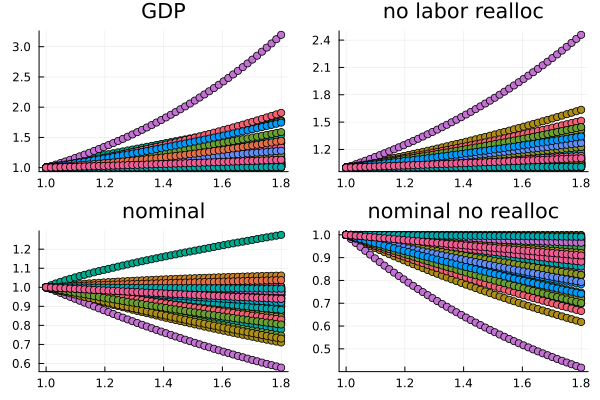

In [50]:
l = @layout [a b; c d]

p1 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP), labels="", title="GDP")
p2 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP_no_realloc), labels="", title="no labor realloc")
p3 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP_nominal), labels="", title="nominal")
p4 = Plots.scatter(LinRange(min_shock, max_shock, shock_count), eachrow(GDP_no_realloc_nominal), labels="", title="nominal no realloc")
Plots.plot(p1, p2, p3, p4, layout=l)

## Wertschöpfung pro Sektor

In [18]:
# Sample shock
deman_shock = ones(71)
supply_shock = ones(71)
shocks = CESModel.Shocks(supply_shock, deman_shock)
#shocks.demand_shock[35] = 1.09
CESModel.calculate_investment!(shocks, data, 25000, "Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten")

1.2048978788971576

In [19]:
price, quantity = CESModel.solve_ces_model(data, shocks, elasticities)

([0.9414662771283996, 0.6855770600909871, 0.6244054586459472, 0.7988094318208036, 0.72560800011063, 0.7980692412591359, 0.9413472751142242, 0.8399371285656841, 0.7209376231454446, 0.9065230798549605  …  0.9374540563116732, 0.9365461354636719, 0.9396953689492532, 0.9447017210433897, 0.9573774851060077, 0.938480831665168, 0.9357786376989151, 0.9267620543014244, 0.8651271003502765, 0.9377494149784271], [0.017822842569161338, 0.0026980482430791456, 0.00019236861163893568, 0.001048461529185728, 0.0005707884229604307, 0.005050754335328761, 0.06459037348601991, 0.007634823324171928, 0.009157820799896372, 0.014907716432191008  …  0.08476074351186004, 0.011993745199906808, 0.05922054719919948, 0.07762445712314177, 0.034953554011502665, 0.011428410192898692, 0.009859295553372088, 0.014517220159642874, 0.0015135389093517662, 0.01793051333348333])

In [20]:
value_added = CESModel.gross_incease(price,quantity,data);
value_added_nominal = CESModel.nominal_increase(quantity,data);

In [21]:
println("Summe der Wertschöpfungen: $(sum(value_added))")
println("Summe der nominalen Wertschöpfungen: $(sum(value_added_nominal))")

Summe der Wertschöpfungen: 28328.780881343795
Summe der nominalen Wertschöpfungen: 4748.89819453327


In [63]:
rand(1:20,10)

10-element Vector{Int64}:
 10
 16
 18
  7
  5
 13
 11
 20
 19
  2